# NeRF: Neural Radiance Fields

- https://www.matthewtancik.com/nerf
- https://arxiv.org/abs/2003.08934

## Data

In [ ]:
import os

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

In [ ]:
import numpy as np

In [ ]:
data = np.load('tiny_nerf_data.npz')

In [ ]:
list(data.keys())

['images', 'poses', 'focal']

In [ ]:
images = data['images']
poses  = data['poses']
focal  = data['focal']

This dataset consists of 106 images taken of the synthetic Lego bulldozer along with poses and a common focal length value.

In [ ]:
print(f'Images shape : {images.shape}')
print(f'Poses  shape : {poses.shape}')
print(f'Focal  length: {focal}')

Images shape : (106, 100, 100, 3)
Poses  shape : (106, 4, 4)
Focal  length: 138.88887889922103


In [ ]:
import matplotlib.pyplot as plt

Image index: 37
Pose
[[-0.46346596 -0.8589089   0.21788737  0.87833214]
 [ 0.8861148  -0.4492364   0.11396196  0.45939538]
 [ 0.          0.24589068  0.96929747  3.9073634 ]
 [ 0.          0.          0.          1.        ]]


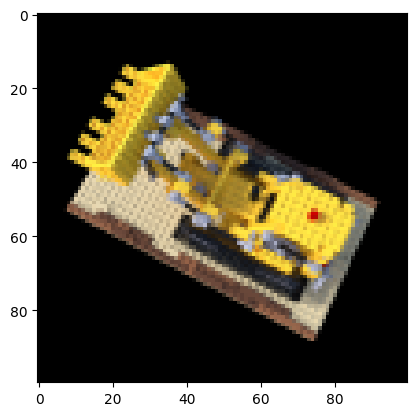

In [ ]:
idx = np.random.randint(images.shape[0])
print(f'Image index: {idx}')

sample_img  = images[idx]
sample_pose = poses[idx]

plt.imshow(sample_img)

print('Pose')
print(sample_pose)

In [ ]:
sample_img.min(), sample_img.max(), sample_img.dtype

(np.float32(0.0), np.float32(1.0), dtype('float32'))

## Pinhole camera model

- [Pinhole camera model](https://en.wikipedia.org/wiki/Pinhole_camera_model)
- [Camera matrix](https://en.wikipedia.org/wiki/Camera_matrix)

**Pose Matrix**

The pose matrix $P$ is a $4 \times 4$ transformation matrix defined as:
$$
P = 
\begin{bmatrix}
R & t \\
0 & 1
\end{bmatrix}
$$
where:
- $R \in \mathbb{R}^{3 \times 3}$ is the **rotation matrix**, representing the orientation of the camera in the world space.
- $t \in \mathbb{R}^3$ is the **translation vector**, representing the position of the camera in the world space.
- The last row $\begin{bmatrix} 0 & 0 & 0 & 1 \end{bmatrix}$ allows the matrix to be used in homogeneous coordinates.

In [ ]:
dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
print(dirs.shape)

(106, 3)


This code computes the direction vectors for the camera.

[0, 0, -1] represents the forward-facing direction of the camera in its local coordinate system (the camera typically looks down the negative Z-axis in OpenGL/graphics conventions).

pose[:3, :3] is the rotation part of the pose matrix, which transforms the forward direction [0, 0, -1] from the camera's local space to the world space.

In [ ]:
# unit direction vector
print(dirs[idx])
(dirs[idx]**2).sum()

[-0.21788737 -0.11396196 -0.96929747]


np.float64(0.9999998172689231)

In [ ]:
origins = poses[:, :3, -1]
print(origins.shape)

(106, 3)


This extracts the translation part (the camera position in the world space) for each pose.

The camera is initially at the origin.

poses[:, :3, -1] accesses the last column of the first three rows of each pose matrix.

Image index: 91


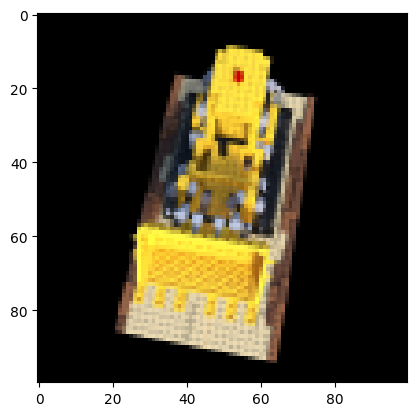

Pose
[[ 9.8336297e-01 -1.7399617e-01  5.2178759e-02  2.1033931e-01]
 [ 1.8165155e-01  9.4192082e-01 -2.8246751e-01 -1.1386629e+00]
 [ 7.4505802e-09  2.8724650e-01  9.5785671e-01  3.8612440e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
Direction
[-0.05217876  0.28246751 -0.95785671]
Origin
[ 0.21033931 -1.1386629   3.861244  ]


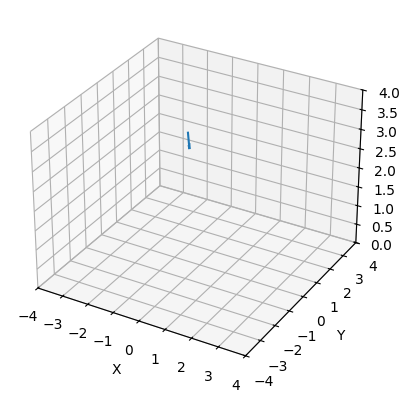

In [ ]:
idx = np.random.randint(images.shape[0])
print(f'Image index: {idx}')

sample_img  = images[idx]
sample_pose = poses[idx]
sample_dir = dirs[idx]
sample_ori = origins[idx]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(sample_img)
plt.show()

print('Pose')
print(sample_pose)

print('Direction')
print(sample_dir)

print('Origin')
print(sample_ori)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(sample_ori[0], sample_ori[1], sample_ori[2], 
          sample_dir[0], sample_dir[1], sample_dir[2], 
          length=0.5, normalize=True)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_zlim(0, 4)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

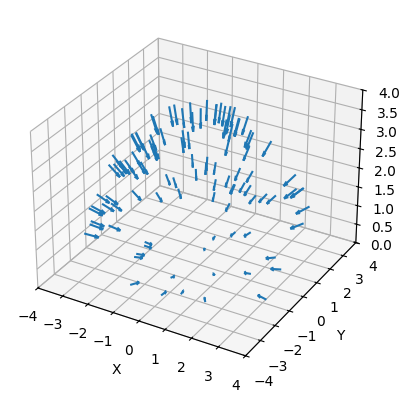

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(
  origins[..., 0].flatten(),
  origins[..., 1].flatten(),
  origins[..., 2].flatten(),
  dirs[..., 0].flatten(),
  dirs[..., 1].flatten(),
  dirs[..., 2].flatten(), 
  length=0.5, normalize=True
)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_zlim(0, 4)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Get rays from a camera

In [ ]:
import torch

**Apply pinhole camera model to gather directions at each pixel**

- The pinhole camera model assumes that the camera projects 3D points onto a 2D image plane.
- Each pixel corresponds to a 3D ray originating from the camera's origin and passing through the image plane.
- The 3D direction vector for each pixel $(i, j)$ is given by:

$$
\mathbf{d}_{i,j} = \left( \frac{i - W/2}{f}, -\frac{j - H/2}{f}, -1 \right),
$$

where:
- $W$: Image width (number of pixels along the x-axis),
- $H$: Image height (number of pixels along the y-axis),
- $f$: Focal length (determines the field of view of the camera).

```python
directions = torch.stack([
         (i - width * 0.5) / focal_length,
        -(j - height * 0.5) / focal_length,
        -torch.ones_like(i)
   ], dim=-1)
```

`(i - width * 0.5)` and `(j - height * 0.5)` are offsets that center the image plane at the origin. In an image, the top-left corner corresponds to (0,0), but for the pinhole camera model, we assume that the center of the image is at (0,0) for more convenient mathematical representation.

We divide by `focal_length` to normalize the pixel offsets into camera-space units. This gives us the normalized coordinates in terms of angular directions.

`-torch.ones_like(i)` represents the z-component of the direction, which is always negative (assuming a camera looking along the negative z-axis). This corresponds to the camera's line of sight along the z-axis.

The resulting directions tensor is a 3D tensor of shape `(height, width, 3)` containing the direction vectors of the rays, pointing from the camera's viewpoint toward each pixel on the image plane.

$$
\mathbf{d}_{\text{cam}} = \begin{bmatrix}
   \frac{i - \frac{\text{width}}{2}}{f} \\
   -\frac{j - \frac{\text{height}}{2}}{f} \\
   -1
\end{bmatrix}
$$

**Transforming Directions into World Space**

```python
rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)
```

The directions in the camera's local coordinate system are in the form of unit vectors pointing out from the pinhole through each pixel. To convert these directions into world space, we multiply them by the camera-to-world (c2w) rotation matrix `c2w[:3, :3]`.

`directions[..., None, :]` adds an extra dimension to the directions tensor, allowing us to perform the matrix multiplication in the next step.

`c2w[:3, :3]` is the upper-left 3x3 portion of the camera-to-world transformation matrix that represents the rotation from the camera coordinate system to the world coordinate system.

`torch.sum(..., dim=-1)` performs the summation along the last dimension (the direction components), effectively applying the rotation to each direction vector. The result is the ray directions in world space.

$$
\mathbf{d}_{\text{world}} = \mathbf{R} \cdot \mathbf{d}_{\text{cam}}
$$

**Setting Ray Origins**

```python
rays_o = c2w[:3, -1].expand(rays_d.shape)
```

`c2w[:3, -1]` extracts the translation component of the camera-to-world transformation matrix. This is a 3D vector representing the camera's position in world coordinates.

`.expand(rays_d.shape)` expand this to match the shape of `rays_d`, ensuring all rays share the same origin.
$$
\mathbf{o}_{\text{world}} = \mathbf{t} \quad (\text{translation from } \texttt{c2w})
$$

In [ ]:
def get_rays(height, width, focal_length, c2w):
    """
    Find origin and direction of rays through every pixel and camera origin.

    Inputs:
        height: Image height.
        width: Image width.
        focal_length: Focal length of camera.
        c2w: A 4x4 camera-to-world transformation matrix (extrinsic parameters).

    Returns: (world coordinates)
        rays_o: Ray origins, which are the camera's optical center for all rays.
        rays_d: Ray directions for each pixel on the image plane
    """

    # Create meshgrid for pixel coordinates in the image plane
    i, j = torch.meshgrid(
        torch.arange(width, dtype=torch.float32).to(c2w.device),
        torch.arange(height, dtype=torch.float32).to(c2w.device),
        indexing='xy'  # Computer Graphics convention
    )

    # Compute directions in camera coordinates
    directions = torch.stack([
         (i - width * 0.5) / focal_length,
        -(j - height * 0.5) / focal_length,
        -torch.ones_like(i)
    ], dim=-1)  # (height, width, 3)

    # Convert directions to world coordinates
    rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)

    # Camera origin in world coordinates
    rays_o = c2w[:3, -1].expand(rays_d.shape)

    return rays_o, rays_d

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data = np.load('tiny_nerf_data.npz')

images = torch.from_numpy(data['images']).to(device)
poses  = torch.from_numpy(data['poses']).to(device)
focal  = torch.from_numpy(data['focal']).to(device)
print("Focal length")
print(focal)
print()

idx = 101
sample_img  = images[idx]
sample_pose = poses[idx]
print("Test Pose")
print(sample_pose)
print()

# Grab rays from sample image
height, width = sample_img.shape[:2]
print("height, width")
print(height, width)
print()
with torch.inference_mode():
    ray_origin, ray_direction = get_rays(height, width, focal, sample_pose)

print("Ray Origin")
print(ray_origin.shape)
print(ray_origin[0, 0, :])                    # Ray origin at (0, 0) pixel (Same as camera origin)
print(ray_origin[height//2, width//2, :])     # Camera origin
print()

print("Ray Direction")
print(ray_direction.shape)
print(ray_direction[0, 0, :])                 # Ray direction at (0, 0) pixel
print(ray_direction[height//2, width//2, :])  # Camera direction
print()

# The ray direction above should be the same as the below camera direction
torch.sum(torch.FloatTensor([0, 0, -1]).to(device) * sample_pose[:3, :3], axis=-1)

Focal length
tensor(138.8889, device='cuda:0', dtype=torch.float64)

Test Pose
tensor([[ 6.8935e-01,  5.3373e-01, -4.8982e-01, -1.9745e+00],
        [-7.2443e-01,  5.0789e-01, -4.6611e-01, -1.8789e+00],
        [ 1.4901e-08,  6.7615e-01,  7.3676e-01,  2.9700e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')

height, width
100 100

Ray Origin
torch.Size([100, 100, 3])
tensor([-1.9745, -1.8789,  2.9700], device='cuda:0')
tensor([-1.9745, -1.8789,  2.9700], device='cuda:0')

Ray Direction
torch.Size([100, 100, 3])
tensor([ 0.4338,  0.9097, -0.4933], device='cuda:0')
tensor([ 0.4898,  0.4661, -0.7368], device='cuda:0')



tensor([ 0.4898,  0.4661, -0.7368], device='cuda:0')

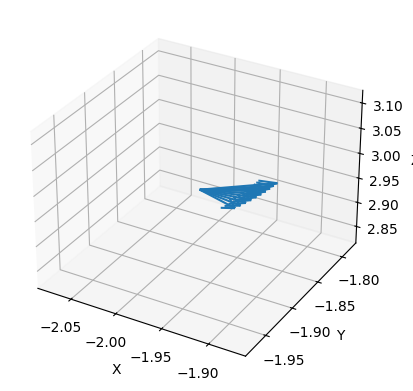

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(
  ray_origin[..., 0].flatten().cpu()[::1000],
  ray_origin[..., 1].flatten().cpu()[::1000],
  ray_origin[..., 2].flatten().cpu()[::1000],
  ray_direction[..., 0].flatten().cpu()[::1000],
  ray_direction[..., 1].flatten().cpu()[::1000],
  ray_direction[..., 2].flatten().cpu()[::1000], 
  length=0.1, normalize=True
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

### Sum up

In [ ]:
data = np.load('tiny_nerf_data.npz')

images = torch.from_numpy(data['images']).to(device)
poses  = torch.from_numpy(data['poses']).to(device)
focal  = torch.from_numpy(data['focal']).to(device)

In [ ]:
idx = 101
sample_img  = images[idx]
sample_pose = poses[idx]
print(sample_img.shape)
print(sample_pose.shape)

height, width = sample_img.shape[:2]
with torch.inference_mode():
    ray_origin, ray_direction = get_rays(height, width, focal, sample_pose)
print(ray_origin.shape)
print(ray_direction.shape)

torch.Size([100, 100, 3])
torch.Size([4, 4])
torch.Size([100, 100, 3])
torch.Size([100, 100, 3])


## NeRF

- MLP
$$
F_{\Theta}: (\mathbf{x}, \mathbf{d}) \rightarrow (\mathbf{c}(\mathbf{x}, \mathbf{d}), \sigma(\mathbf{x}))
$$

- Construct a ray $\mathbf{r}(t)$ from origin $\mathbf{o}$ and direction $\mathbf{d}$
$$
\mathbf{r}(t) = \mathbf{o} + t \mathbf{d}
$$

- Sampling $\{t_{i}\}_{i=1}^{N}$ for near and far bounds $t_n$ and $t_f$

- Using the MLP, get $\sigma_i=\sigma(\mathbf{r}(t_i))$ and $\mathbf{c}_{i}=\mathbf{c}(\mathbf{r}(t_i), \mathbf{d})$

- The expected color $\hat{C}(\mathbf{r})$:
$$
\hat{C}(\mathbf{r}) = \sum_{i}^{N}w_i\mathbf{c}_i
$$

where:
$$
w_i = T_i \alpha_i
$$

$$
T_i = \prod_{j=1}^{i-1}(1 - \alpha_j)
$$

$$
\alpha_i = 1 - \exp(-\sigma_i \delta_i)
$$

$$
\delta_i = t_{i+1} - t_i
$$

## Positional encoding

$$
F_{\Theta} = F'_{\Theta} \circ \gamma
$$

- $\gamma$ is a mapping from $\R$ into a higher dimensional space $\R^{2L}$:

$$
\gamma(p) = (\sin(2^{0}\pi p), \cos(2^{0}\pi p), \cdots, \sin(2^{L-1}\pi p), \cos(2^{L-1}\pi p))
$$

This function $\gamma(\cdot)$ is applied separately to each of the three coordinates values in $\mathbf{x}$ (which are normalized to lie in [-1, 1]) and to the three components of the Cartesian viewing direction unit vector $\mathbf{d}$ (which by construction lie in [-1, 1]).

In the original NeRF paper, they set $L=10$ for $\gamma(\mathbf{x})$ and $L=4$ for $\gamma(\mathbf{d})$.

In [ ]:
def positional_encoding(x, L):
    out = []
    for j in range(L):
        out.append(torch.sin(2 ** j * x))
        out.append(torch.cos(2 ** j * x))
    return torch.cat(out, dim=1)

In [ ]:
x = torch.linspace(-1, 1, 30).view(-1, 3)
print(x.shape)
gx = positional_encoding(x, 10)
print(gx.shape)

torch.Size([10, 3])
torch.Size([10, 60])


In [ ]:
from torch import nn

In [ ]:
class NeRF(nn.Module):
    def __init__(self, emb_dim_pos=10, emb_dim_dir=4, hidden_dim=128):
        super().__init__()
        self.emb_dim_pos = emb_dim_pos
        self.emb_dim_dir = emb_dim_dir

        self.block1 = nn.Sequential(
            nn.Linear(6*emb_dim_pos, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Linear(hidden_dim + 6*emb_dim_pos, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )

        self.sigma = nn.Sequential(
            nn.Linear(hidden_dim, 1), nn.ReLU()        # non-negative
        )
        self.color = nn.Sequential(
            nn.Linear(hidden_dim + 6*emb_dim_dir, hidden_dim//2), nn.ReLU(),
            nn.Linear(hidden_dim//2, 3), nn.Sigmoid()  # RGB color
        )

    @staticmethod
    def positional_encoding(x, L):
        out = []
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)
    
    def forward(self, x, d):
        emb_x = self.positional_encoding(x, self.emb_dim_pos)  # (batch_size, 6*emb_dim_pos)
        emb_d = self.positional_encoding(d, self.emb_dim_dir)  # (batch_size, 6*emb_dim_dir)
        h = self.block1(emb_x)           # (batch_size, hidden_dim)
        h = torch.cat((h, emb_x), dim=1) # skip connection: (batch_size, hidden_dim + 6*emb_dim_pos)
        h = self.block2(h)               # (batch_size, hidden_dim)
        sig = self.sigma(h)              # (batch_size, 1)
        h = torch.cat((h, emb_d), dim=1) # viewing direction condition: (batch_size, hidden_dim + 6*emb_dim_dir)
        c = self.color(h)                # (batch_size, hidden_dim//2)
        return c, sig

## Stratified Sampling

In [ ]:
def compute_accumulated_transmittance(alphas):
    # alphas: (number_of_rays, n_bins)

    accumulated_transmittance = torch.cumprod(alphas, dim=1)
    # (number_of_rays, n_bins): Accumulated transmittance at each bin

    ones = torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device)
    # (number_of_rays, 1): Transmittance at the first bin is 1

    transmittance = torch.cat((ones, accumulated_transmittance[:, :-1]), dim=-1)
    return transmittance  # (number_of_rays, n_bins): Transmittance at each bin


def sampling(ray_origins, tn, tf, n_bins, perturb=True):
    # number_of_rays = batch_size
    # ray_origins: (number_of_rays, 3)
    device = ray_origins.device

    # Get t values for sampling along each ray
    t = torch.linspace(tn, tf, n_bins, device=device)  # (n_bins)
    t = t.expand(ray_origins.shape[0], n_bins)         # (number_of_rays, n_bins): Repeat for all rays

    # Draw uniform samples from bins along ray (Stratified Sampling)
    if perturb:
        mid = (t[:, :-1] + t[:, 1:]) / 2.
        lower = torch.cat((t[:, :1], mid), -1)
        upper = torch.cat((mid, t[:, -1:]), -1)
        u = torch.rand(t.shape, device=device)
        t = lower + (upper - lower) * u  # (number_of_rays, n_bins)

    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10], device=device).expand(ray_origins.shape[0], 1)), -1)
    # (number_of_rays, n_bins): Distance between each bin along the ray

    return t, delta


def render_rays(nerf_model, ray_origins, ray_directions, tn=0, tf=0.5, n_bins=192, perturb=True):
    # number_of_rays = batch_size
    # ray_origins: (number_of_rays, 3)
    # ray_directions: (number_of_rays, 3)

    t, delta = sampling(ray_origins, tn, tf, n_bins, perturb)
    
    # Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)   # (number_of_rays, n_bins, 3)

    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(n_bins, ray_directions.shape[0], 3).transpose(0, 1)  
    # (number_of_rays, n_bins, 3); Repeat the same direction for all bins

    # (number_of_rays*n_bins, 3), (number_of_rays*n_bins, 1)
    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    colors = colors.reshape(x.shape)     # (number_of_rays, n_bins, 3)
    sigma = sigma.reshape(x.shape[:-1])  # (number_of_rays, n_bins)

    # Compute weights
    alpha = 1 - torch.exp(-sigma * delta)  # (number_of_rays, n_bins)
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)
    # (number_of_rays, n_bins, 1)

    # Compute the pixel values as a weighted sum of colors along each ray
    c = (weights * colors).sum(dim=1)
    # (number_of_rays, n_bins, 1) * (number_of_rays, n_bins, 3) -> (number_of_rays, 3)
    return c  # (number_of_rays, 3)

In [ ]:
@torch.inference_mode()
def test(nerf_model, tn, tf, ray_origins, ray_directions, chunk_size=10, n_bins=192, H=100, W=100, filename=None):
    """
    Args:
        nerf_model: NeRF model
        tn: near plane distance
        tf: far plane distance
        ray_origins: ray origins for each pixel of the image
        ray_directions: ray directions for each pixel of the image
        chunk_size (int, optional): chunk size for memory efficiency. Defaults to 10.
        n_bins (int, optional): number of bins for density estimation. Defaults to 192.
        H (int, optional): image height. Defaults to 100.
        W (int, optional): image width. Defaults to 100.
        
    Returns:
        None: None
    """

    pixels = []   # list of regenerated pixel values
    for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        # Get chunk of rays
        ray_o = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_d = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)        
        regenerated_px_values = render_rays(nerf_model, ray_o, ray_d, tn=tn, tf=tf, n_bins=n_bins)
        pixels.append(regenerated_px_values)
    img = torch.cat(pixels).data.cpu().numpy().reshape(H, W, 3)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(img)
    ax.axis('off')
    if filename:
        fig.savefig(filename, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    return img

In [ ]:
idx = 101
sample_img  = images[idx]
sample_pose = poses[idx]
height, width = sample_img.shape[:2]
with torch.inference_mode():
    ray_origin, ray_direction = get_rays(height, width, focal, sample_pose)

ray_o = ray_origin.view(-1, 3)
ray_d = ray_direction.view(-1, 3)
print(ray_o.shape)
print(ray_d.shape)

torch.Size([10000, 3])
torch.Size([10000, 3])


torch.Size([10000, 3])


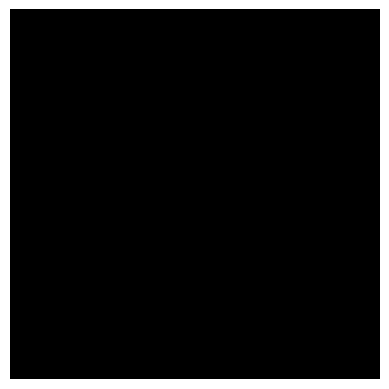

In [ ]:
model = NeRF().to(device)
with torch.inference_mode():
    c = render_rays(model, ray_o, ray_d, tn=2, tf=6, n_bins=192)
print(c.shape)

test(model, 2, 6, ray_o, ray_d, chunk_size=10, n_bins=192, H=height, W=width);

torch.Size([10000, 8])
torch.Size([10000, 8])


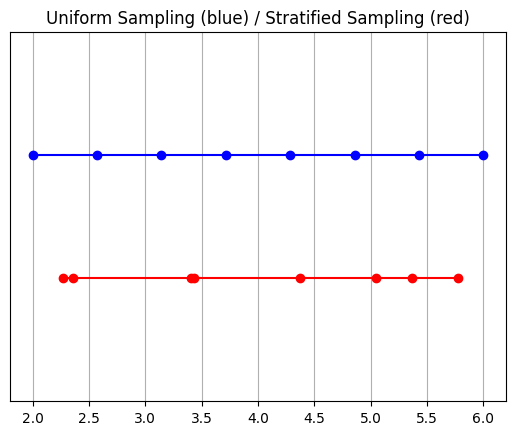

In [ ]:
with torch.inference_mode():
    t_uniform, _ = sampling(ray_o, 2, 6, 8, perturb=False)
    t_stratified, _ = sampling(ray_o, 2, 6, 8, perturb=True)

print(t_uniform.shape)
print(t_stratified.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_uniform[0].cpu(), torch.ones_like(t_uniform[0]).cpu(), 'bo-')
ax.plot(t_stratified[0].cpu(), torch.zeros_like(t_stratified[0]).cpu(), 'ro-')
ax.set_ylim([-1, 2])
ax.set_title('Uniform Sampling (blue) / Stratified Sampling (red)')
ax.grid(True)
ax.axes.yaxis.set_visible(False)
plt.show()

## Dataset

In [ ]:
data = np.load('tiny_nerf_data.npz')

images = torch.from_numpy(data['images']).to(device)
poses  = torch.from_numpy(data['poses']).to(device)
focal  = torch.from_numpy(data['focal']).to(device)

ray_origin_list = []
ray_direction_list = []

for i in range(images.shape[0]):
    height, width = images[i].shape[:2]
    with torch.inference_mode():
        ray_origin, ray_direction = get_rays(height, width, focal, poses[i])
    ray_origin_list.append(ray_origin)
    ray_direction_list.append(ray_direction)

ray_origins = torch.stack(ray_origin_list, dim=0)
ray_directions = torch.stack(ray_direction_list, dim=0)

In [ ]:
print(images.shape)
print(ray_origins.shape)
print(ray_directions.shape)

torch.Size([106, 100, 100, 3])
torch.Size([106, 100, 100, 3])
torch.Size([106, 100, 100, 3])


In [ ]:
n_train = 100

train_images = images[:n_train].view(-1, 3)
train_ray_origins = ray_origins[:n_train].view(-1, 3)
train_ray_directions = ray_directions[:n_train].view(-1, 3)

In [ ]:
train_images.shape, train_ray_origins.shape, train_ray_directions.shape

(torch.Size([1000000, 3]), torch.Size([1000000, 3]), torch.Size([1000000, 3]))

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class NeRFDataset(Dataset):
    def __init__(self, images, ray_origins, ray_directions):
        self.images = images
        self.ray_origins = ray_origins
        self.ray_directions = ray_directions

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], self.ray_origins[idx], self.ray_directions[idx]

In [ ]:
dataset = NeRFDataset(train_images, train_ray_origins, train_ray_directions)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
for batch in dataloader:
    break
# image, ray_origin, ray_direction
batch[0].shape, batch[1].shape, batch[2].shape

(torch.Size([1024, 3]), torch.Size([1024, 3]), torch.Size([1024, 3]))

In [ ]:
from tqdm.auto import tqdm
from pathlib import Path

def train(nerf_model, optimizer, scheduler, data_loader, device='cpu', n_epochs=int(1e5),
          tn=0, tf=1, n_bins=192, H=100, W=100, freq=10000,
          test_ray_o=None, test_ray_d=None, output_dir='output'):
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    losses = []
    for epoch in range(n_epochs):
        train_loader = tqdm(data_loader)
        train_loader.set_description(f'Epoch {epoch}')
        for batch_idx, batch in enumerate(train_loader):
            global_step = epoch * len(data_loader) + batch_idx
            ground_truth_px_values = batch[0].to(device)
            ray_origins = batch[1].to(device)
            ray_directions = batch[2].to(device)

            regenerated_px_values = render_rays(nerf_model, ray_origins, ray_directions, tn=tn, tf=tf, n_bins=n_bins)
            loss = ((ground_truth_px_values - regenerated_px_values) ** 2).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if global_step % freq == 0:
                test(nerf_model, tn, tf, test_ray_o, test_ray_d, chunk_size=10, n_bins=n_bins, H=H, W=W,
                     filename=output_dir / f'img_{global_step}.png')
                
                torch.save(nerf_model.state_dict(), output_dir / f'model_{global_step}.pth')
        print(f'Epoch {epoch} Loss: {losses[-1]}')
        scheduler.step()

    torch.save(nerf_model.state_dict(), output_dir / 'model.pth')
    return losses

## Train

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = torch.from_numpy(data['images']).to(device)
poses  = torch.from_numpy(data['poses']).to(device)
focal  = torch.from_numpy(data['focal']).to(device)
ray_origin_list = []
ray_direction_list = []
for i in range(images.shape[0]):
    height, width = images[i].shape[:2]
    with torch.inference_mode():
        ray_origin, ray_direction = get_rays(height, width, focal, poses[i])
    ray_origin_list.append(ray_origin)
    ray_direction_list.append(ray_direction)
ray_origins = torch.stack(ray_origin_list, dim=0)
ray_directions = torch.stack(ray_direction_list, dim=0)

n_train = 100
train_images = images[:n_train].view(-1, 3)
train_ray_origins = ray_origins[:n_train].view(-1, 3)
train_ray_directions = ray_directions[:n_train].view(-1, 3)

dataset = NeRFDataset(train_images, train_ray_origins, train_ray_directions)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [ ]:
model = NeRF(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1, 2, 4, 8], gamma=0.5)

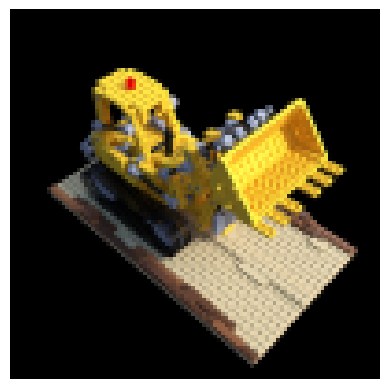

In [ ]:
idx = 101
test_ray_o = ray_origins[idx].view(-1, 3)
test_ray_d = ray_directions[idx].view(-1, 3)

test_img = images[idx]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(test_img.cpu())
ax.axis('off')
plt.show()

In [ ]:
losses = train(model, optimizer, scheduler, dataloader, device=device, n_epochs=4, freq=500,
               tn=2, tf=6, n_bins=192, H=100, W=100,
               test_ray_o=test_ray_o, test_ray_d=test_ray_d)

  0%|          | 0/977 [00:00<?, ?it/s]

Epoch 0 Loss: 13.914677619934082


  0%|          | 0/977 [00:00<?, ?it/s]

Epoch 1 Loss: 8.785484313964844


  0%|          | 0/977 [00:00<?, ?it/s]

Epoch 2 Loss: 7.869241237640381


  0%|          | 0/977 [00:00<?, ?it/s]

Epoch 3 Loss: 6.151750564575195


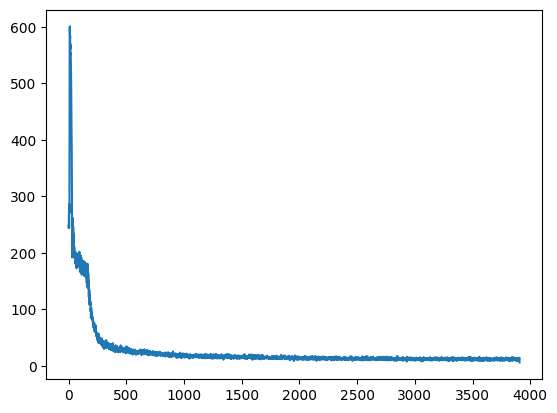

In [ ]:
plt.plot(losses);

In [ ]:
model.load_state_dict(torch.load('output/model.pth', map_location=device, weights_only=True))

<All keys matched successfully>

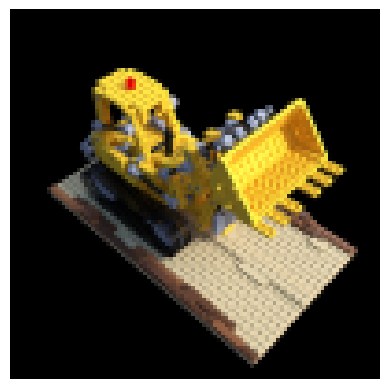

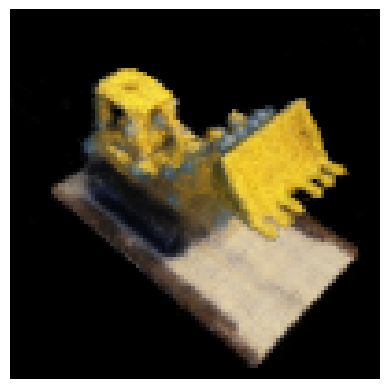

In [ ]:
idx = 101
test_ray_o = ray_origins[idx].view(-1, 3)
test_ray_d = ray_directions[idx].view(-1, 3)

test_img = images[idx]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(test_img.cpu())
ax.axis('off')
plt.show()

test(model, 2, 6, test_ray_o, test_ray_d, chunk_size=10, n_bins=192, H=100, W=100);